In [33]:
import pennylane as qml
from pennylane import numpy as np
from functools import reduce
import cirq

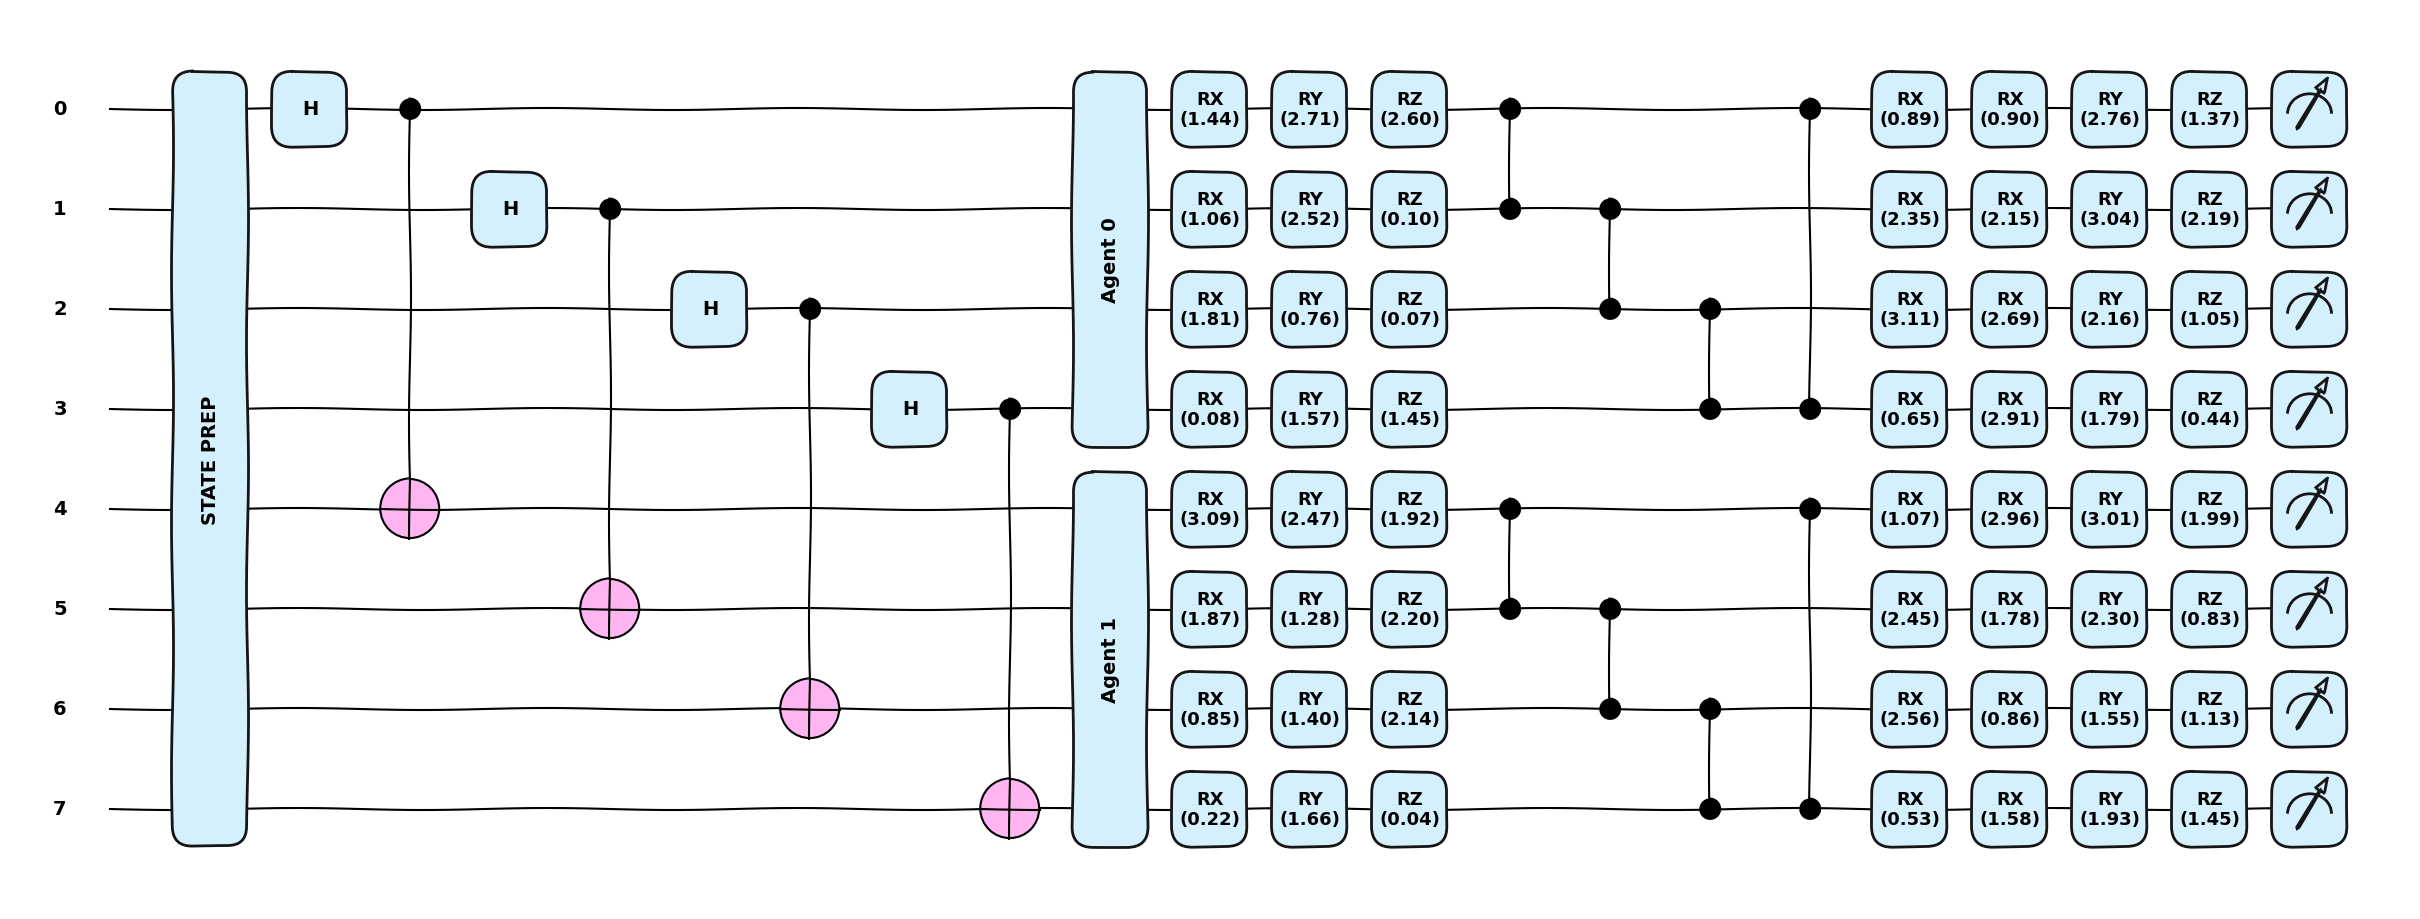

In [94]:
def variational_rotation_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[i][0], wires=wire)
        qml.RY(phi=phi[i][1], wires=wire)
        qml.RZ(phi=phi[i][2], wires=wire)


def circular_entangling_layer(
    wires: list[int],
    ):
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    for w0, w1 in zip(wires, wires[1:]):
        qml.CZ(wires=[w0, w1])
    if len(wires) != 2:
        qml.CZ(wires=[wires[0], wires[-1]]) # Entangle the first and last qubit.


def single_rotation_encoding_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[i], wires=wire)


def variational_encoding_pqc(
    wires: list[int],
    n_layers: int,
    var_thetas: np.ndarray,
    enc_inputs: np.ndarray,
    ):
    n_var_rotations = 3
    n_wires = len(wires)
    d = n_wires
    
    var_thetas = np.asarray(var_thetas)
    assert var_thetas.shape == (n_layers+1, d, n_var_rotations), "var_thetas must have shape (n_layers+1, d, n_var_rotations)"
    
    enc_inputs = np.asarray(enc_inputs)
    assert enc_inputs.shape == (n_layers, d), "enc_inputs must have shape (n_layers, d)"
    
    for l in range(n_layers):
        variational_rotation_layer(wires, var_thetas[l])
        circular_entangling_layer(wires)
        single_rotation_encoding_layer(wires, enc_inputs[l])
    variational_rotation_layer(wires, var_thetas[n_layers])


## Functions to create various entangled input states.


def entangle_agents_phi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_phi_minus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_psi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Psi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])
            

def entangle_agents_psi_minus(wires: list[int], d: int, n: int):
    """Entangles via $\\Psi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def TensorPauliZ(wires, n, d) -> list:
    all_obs = []
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
        obs = reduce((lambda a, b: a @ b), ops)
        all_obs.append(obs)
        all_obs.append(-obs)
    return all_obs


def IndividualPauliZ(wires) -> list:
    all_obs = []
    for w in wires:
        obs = qml.PauliZ(w)
        all_obs.append(obs)
    return all_obs



class AnnotationGate(qml.Identity):
    """This gate behaves like the Identity, but allows users to modify the string label of the gate when printed or drawn."""
    
    def __init__(self, annotation: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.annotation = annotation
    
    def label(self, decimals=None, base_label=None, cache=None):
        return base_label or self.annotation


def circuit(
    wires: list,
    d: int, # qubit dimensions for each agent
    n: int, # number of agents
    n_layers: int,
    agents_var_thetas: np.ndarray,
    agents_enc_inputs: np.ndarray,
    initial_state_vector: str|np.ndarray = None,
    obs_func = lambda wires: TensorPauliZ(wires, n, d),
    annotations: bool = False,
    ):
    # n_wires = len(wires)
    
    # for w in wires:
    #     # qml.Hadamard(wires=w)
    #     qml.RX()
    
    # Variational parameters.
    # symbol_superscript_index = None
    n_var_rotations = 3
    
    agents_var_thetas = np.asarray(agents_var_thetas)
    assert agents_var_thetas.shape == (n, n_layers+1, d, n_var_rotations), "agents_var_thetas must have shape (n, n_layers+1, d, n_var_rotations)"
    
    agents_enc_inputs = np.asarray(agents_enc_inputs)
    assert agents_enc_inputs.shape == (n, n_layers, d), "agents_enc_inputs must have shape (n, n_layers, d)"
    
    # var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    # var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))
    
    
    # for l in range(n_layers):
    #     variational_rotation_layer(wires, var_thetas[l])
    #     circular_entangling_layer(wires)
    #     single_rotation_encoding_layer(wires, enc_inputs[l])
    # variational_rotation_layer(wires, var_thetas[n_layers])
    
    measurements = []
    
    # entangle_agents_phi_plus(wires, d, n)
    
    if annotations: AnnotationGate('STATE PREP', wires=wires)
    
    # Prepare initial state.
    if isinstance(initial_state_vector, str):
        match initial_state_vector:
            case 'phi+':
                entangle_agents_phi_plus(wires, d, n)
            case 'phi-':
                entangle_agents_phi_minus(wires, d, n)
            case 'psi+':
                entangle_agents_psi_plus(wires, d, n)
            case 'psi-':
                entangle_agents_psi_minus(wires, d, n)

    elif initial_state_vector is not None:
        qml.QubitStateVector(initial_state_vector, wires=wires)

    # qml.operation.Operator(wires=wires, id='mynaem', name='MYNAME')
    
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        if annotations: AnnotationGate(f'Agent {aidx}', wires=wires[qidx:qidx+d])
        variational_encoding_pqc(
            wires[qidx:qidx+d],
            n_layers,
            agents_var_thetas[aidx],
            agents_enc_inputs[aidx],
            )
    
    # for aidx in range(n):
    #     qidx = aidx * d # Starting qubit index for the specified agent.
    #     ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
    #     obs = reduce((lambda a, b: a @ b), ops)
    #     measurements.append(qml.expval(obs))
    #     measurements.append(qml.expval(-obs))
    obs = obs_func(wires)
    for o in obs:
        measurements.append(qml.expval(o))
    
    # return qml.expval(obs), qml.expval(-obs), qml.state()
    # return np.asarray(measurements)
    return np.asarray(measurements)
    # return *measurements, qml.state()
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(-(qml.PauliZ(0) @ qml.PauliZ(1))), qml.state()
    # return qml.expval(obs), qml.expval(reduce(lambda a, b: a @ b, [qml.PauliX(w) for w in wires])), qml.state()


n = 2
d = 4
wires = list(range(n * d))

n_layers = 1
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))


dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

fig, ax = qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector='phi+', annotations=True)
# print(qml.draw(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ))

In [95]:
print(qml.draw(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ, initial_state_vector='phi+', annotations=True))

0: ─╭STATE PREP──H─╭●───────────────────╭Agent 0──RX(1.44)──RY(2.71)──RZ(2.60)─╭●───────╭●──RX(0.89)
1: ─├STATE PREP────│───H─╭●─────────────├Agent 0──RX(1.06)──RY(2.52)──RZ(0.10)─╰Z─╭●────│───RX(2.35)
2: ─├STATE PREP────│─────│───H─╭●───────├Agent 0──RX(1.81)──RY(0.76)──RZ(0.07)────╰Z─╭●─│───RX(3.11)
3: ─├STATE PREP────│─────│─────│───H─╭●─╰Agent 0──RX(0.08)──RY(1.57)──RZ(1.45)───────╰Z─╰Z──RX(0.65)
4: ─├STATE PREP────╰X────│─────│─────│──╭Agent 1──RX(3.09)──RY(2.47)──RZ(1.92)─╭●───────╭●──RX(1.07)
5: ─├STATE PREP──────────╰X────│─────│──├Agent 1──RX(1.87)──RY(1.28)──RZ(2.20)─╰Z─╭●────│───RX(2.45)
6: ─├STATE PREP────────────────╰X────│──├Agent 1──RX(0.85)──RY(1.40)──RZ(2.14)────╰Z─╭●─│───RX(2.56)
7: ─╰STATE PREP──────────────────────╰X─╰Agent 1──RX(0.22)──RY(1.66)──RZ(0.04)───────╰Z─╰Z──RX(0.53)

───RX(0.90)──RY(2.76)──RZ(1.37)─┤  <Z>
───RX(2.15)──RY(3.04)──RZ(2.19)─┤  <Z>
───RX(2.69)──RY(2.16)──RZ(1.05)─┤  <Z>
───RX(2.91)──RY(1.79)──RZ(0.44)─┤  <Z>
───RX(2.96)──RY(3.01)──RZ(1.99)─┤  

In [40]:
def softmax(x, axis=None):
    return np.exp(x)/np.sum(np.exp(x), axis=axis)

In [45]:
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ)
meas = meas.reshape((n, d)) # Reshape to 2D with (n_agents, d_qubits) because each agent only has 1 observation per qubit.

meas, np.asarray(meas >= 0, dtype=int)

(tensor([[ 0.16670343, -0.06613673,  0.36867245, -0.14952515],
         [ 0.43428305, -0.68541313,  0.30301446,  0.00349638]], requires_grad=True),
 tensor([[1, 0, 1, 0],
         [1, 0, 1, 1]], requires_grad=True))

In [3]:
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)
# meas = np.asarray(meas)
# np.concatenate(meas).reshape((n, 2))

meas, softmax(meas)

(tensor([[ 0.06355885, -0.06355885],
         [-0.05326468,  0.05326468]], requires_grad=True),
 tensor([[0.26594819, 0.23420196],
         [0.23662533, 0.26322452]], requires_grad=True))

In [4]:
# Compute matrix representation for entire circuit.
U = qml.matrix(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
U.shape # for 8 qubits is (256, 256)

(256, 256)

In [5]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects.shape

(256, 256)

In [6]:
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
initial_state_vector

array([ 0.0016566 +2.69362066e-02j, -0.00308242+3.48444772e-02j,
       -0.00029965-1.13800174e-02j,  0.04675063+2.95093654e-02j,
       -0.02535878-1.71242371e-02j,  0.04601832+2.55539051e-03j,
       -0.04937535+2.18203059e-02j, -0.04189063-6.05019119e-02j,
        0.01938951-2.42981628e-02j,  0.02608182+1.71577164e-03j,
       -0.04204764-2.86942458e-02j, -0.01067087+3.56237438e-02j,
       -0.02115574+3.03654072e-02j, -0.03035639-9.32457468e-02j,
        0.048846  +2.34974653e-02j,  0.05091757-5.80844649e-02j,
       -0.03779007+1.89832966e-02j,  0.05436894+3.77963106e-02j,
        0.0186592 +3.08286218e-02j, -0.01703175-4.24701710e-02j,
       -0.04177191+5.67211578e-02j,  0.01831974+5.12652219e-02j,
        0.07065631+2.94028251e-02j,  0.00546987+3.72308249e-02j,
       -0.00790784+3.37886668e-02j, -0.02272137+2.33480994e-02j,
        0.02084881-2.29804353e-02j, -0.04305263-4.26157187e-02j,
        0.06808443+1.97931423e-02j, -0.01629428+3.37363935e-02j,
       -0.00853782-3.1414

(tensor([[ 0.07022248, -0.07022248],
         [ 0.03971687, -0.03971687]], requires_grad=True),
 tensor([[0.26775088, 0.23266788],
         [0.25970631, 0.23987493]], requires_grad=True))

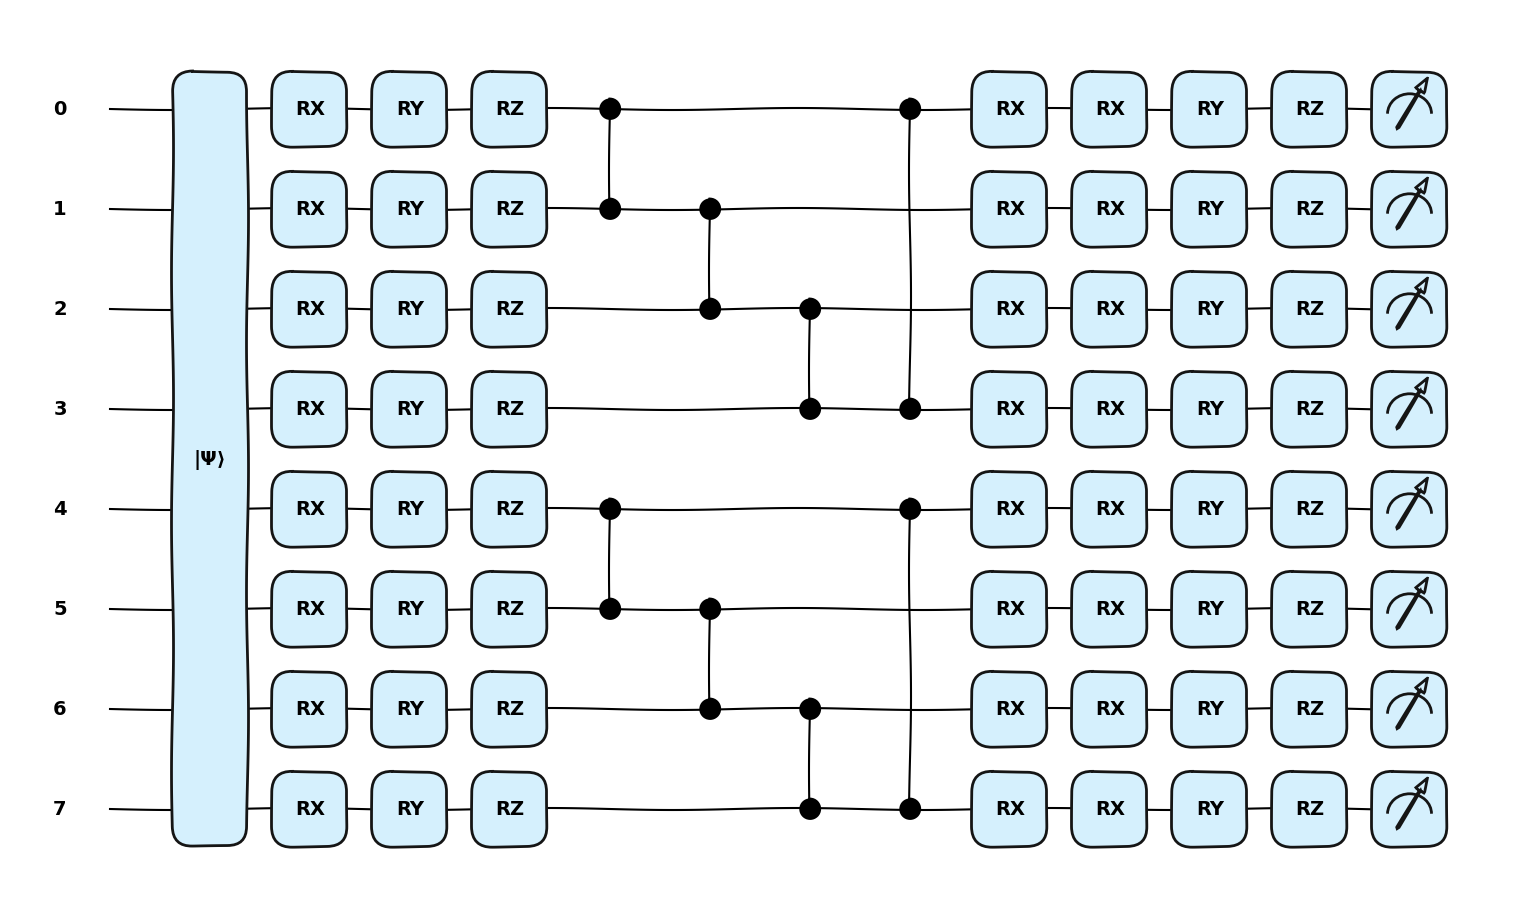

In [7]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane")(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

meas, softmax(meas)

In [22]:
def experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=100):
    history = []
    for i in range(n_runs):
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))
        meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
        meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

        # meas, softmax(meas), np.argmax(softmax(meas), axis=1)
        
        history.append(np.argmax(softmax(meas), axis=1))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [29]:
# Initial state is all zeros (default |0>).
initial_state_vector = None
experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([230, 247, 285, 238]))

In [23]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([259, 238, 254, 249]))

In [24]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([267, 283, 228, 222]))

In [25]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi+'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([635, 137, 180,  48]))

In [26]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi-'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([634, 135, 192,  39]))

In [27]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi+'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([624, 148, 184,  44]))

In [28]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi-'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([614, 131, 208,  47]))

In [46]:
def experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=100):
    history = []
    for i in range(n_runs):
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))
        meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector, obs_func=IndividualPauliZ)
        meas = meas.reshape((n, d)) # Reshape to 2D with (n_agents, d_qubits)
        
        history.append(np.asarray(meas >= 0, dtype=int))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [52]:
initial_state_vector = None

states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)
states, counts

(array([[[0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 1]],
 
        [[0, 0, 0, 0],
         [0, 0, 1, 0]],
 
        ...,
 
        [[1, 1, 1, 1],
         [1, 1, 0, 1]],
 
        [[1, 1, 1, 1],
         [1, 1, 1, 0]],
 
        [[1, 1, 1, 1],
         [1, 1, 1, 1]]]),
 array([ 8,  4,  4,  3,  6,  2,  6,  4,  7,  1,  1,  2,  5,  2,  1,  4,  3,
         3,  5,  3,  5,  4,  3,  4, 10,  6,  7,  3,  2,  6,  4,  3,  5,  3,
         7,  2,  5,  2,  4,  2,  7,  1,  3,  1,  5,  7,  2,  3,  5,  2,  4,
         3,  6,  5,  1,  7,  4,  3,  4,  3,  6,  4,  2,  3,  3,  3,  6,  5,
         4,  4,  1,  5,  9,  1,  2,  5,  6,  3,  3,  2,  2,  6,  2,  2,  1,
         3,  4,  5,  1,  5,  7,  3,  1,  1,  3,  4,  6,  9,  3,  2,  1,  4,
         2,  2,  3,  5,  6,  4,  6,  3,  3,  6,  3,  3,  1,  1,  8,  9,  5,
         4,  2,  5,  5,  5,  5,  5,  6,  2,  4,  1,  2,  3,  2,  5,  6,  3,
         7,  3,  8,  7,  1,  2,  2,  3,  2,  1,  5,  2,  3,  3,  3,  4,  3,
       

In [54]:
initial_state_vector = 'phi+'

states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

In [58]:
states[-10:]

array([[[1, 1, 1, 1],
        [0, 1, 1, 0]],

       [[1, 1, 1, 1],
        [0, 1, 1, 1]],

       [[1, 1, 1, 1],
        [1, 0, 0, 0]],

       [[1, 1, 1, 1],
        [1, 0, 0, 1]],

       [[1, 1, 1, 1],
        [1, 0, 1, 0]],

       [[1, 1, 1, 1],
        [1, 0, 1, 1]],

       [[1, 1, 1, 1],
        [1, 1, 0, 0]],

       [[1, 1, 1, 1],
        [1, 1, 0, 1]],

       [[1, 1, 1, 1],
        [1, 1, 1, 0]],

       [[1, 1, 1, 1],
        [1, 1, 1, 1]]])

In [59]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.
states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

In [60]:
counts

array([ 8,  5,  5,  3,  4,  7,  2,  3,  6,  5,  5,  4,  5,  4,  4,  3,  9,
        1,  4,  4,  8,  6,  3,  5,  2,  2,  3,  4,  5,  5,  5,  3,  7,  6,
        3,  2,  5,  5,  1,  3,  5,  3,  5,  5,  2,  9,  1,  4,  7, 10,  5,
        4,  5,  6,  5,  6,  4,  3,  3,  3,  3,  4,  2,  1,  3,  7,  3,  3,
        2,  2,  3,  4,  1,  4,  5,  3,  4,  1,  4,  4,  3,  4,  1,  2,  3,
        2,  8,  2,  6,  2,  5,  1,  3,  1,  9,  3,  3,  5,  2,  2,  2,  3,
        3,  2,  1,  1,  5,  3,  8,  4,  2,  4,  5,  3,  3,  2,  1,  5,  1,
        3,  3,  2,  1,  1,  4,  1,  4,  4,  4,  5,  1,  3,  7,  3,  7,  3,
        1, 11,  5,  1,  9, 10,  8,  1,  5,  4,  3,  7,  3,  7,  6,  6,  1,
        3,  3,  4,  7,  2,  7,  9,  2,  5,  5,  6,  6,  3,  7,  2,  3,  6,
        6,  3,  7,  6,  3,  2, 10,  3,  6,  8,  3,  2,  2,  3,  3,  5,  4,
        6,  4,  3,  5,  2,  9,  3,  2,  2,  4,  4,  2,  2,  3,  1,  3,  2,
        4,  4,  3,  2,  6,  3,  1,  4,  6,  5,  2,  5,  7,  2,  2,  5,  3,
        2,  4,  2,  3,  5

In [70]:
idx = np.all(states[:,0,:] == states[:,1,:], axis=1)
states[idx], counts[idx]

(array([[[0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 1]],
 
        [[0, 0, 1, 0],
         [0, 0, 1, 0]],
 
        [[0, 0, 1, 1],
         [0, 0, 1, 1]],
 
        [[0, 1, 0, 0],
         [0, 1, 0, 0]],
 
        [[0, 1, 0, 1],
         [0, 1, 0, 1]],
 
        [[0, 1, 1, 0],
         [0, 1, 1, 0]],
 
        [[0, 1, 1, 1],
         [0, 1, 1, 1]],
 
        [[1, 0, 0, 0],
         [1, 0, 0, 0]],
 
        [[1, 0, 0, 1],
         [1, 0, 0, 1]],
 
        [[1, 0, 1, 0],
         [1, 0, 1, 0]],
 
        [[1, 0, 1, 1],
         [1, 0, 1, 1]],
 
        [[1, 1, 0, 0],
         [1, 1, 0, 0]],
 
        [[1, 1, 0, 1],
         [1, 1, 0, 1]],
 
        [[1, 1, 1, 0],
         [1, 1, 1, 0]],
 
        [[1, 1, 1, 1],
         [1, 1, 1, 1]]]),
 array([8, 1, 3, 4, 2, 2, 2, 1, 7, 3, 3, 2, 2, 7, 3, 2]))